In [1]:
import datetime
import os
import re
from collections import Counter
from datetime import datetime, timedelta

import numpy as np
from keras.preprocessing import sequence
import sys
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
import sklearn
import json

import sys
sys.path.append('../')
from ftw_model.extract_feature import computing_feature_wo

/home/simon/miniconda3/envs/casas/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [90]:
def read_hh_dataset(dataset_path):

    ann_dataset = pd.read_csv(dataset_path, sep='\t')

    raw_columns = ['Date & Time', 'Sensor ID', 'Room-level', 'Sensor location', 'Message', 'Sensor Type']
    ann_columns = raw_columns + ['Activity']

    ann_dataset.columns = ann_columns
    # ann_dataset['Activity'] = ann_dataset['Activity'].apply(lambda x: activity_mapping[x] if x in activity_mapping else x)

    ann_dataset['Date & Time'] = pd.to_datetime(ann_dataset['Date & Time'], format='%Y-%m-%d %H:%M:%S')
    start_time, end_time = ann_dataset['Date & Time'].min(), ann_dataset['Date & Time'].max()
    timeframed_dataset = ann_dataset.set_index(['Date & Time'])

    activity2id = {}
    count = 0
    for act in ann_dataset['Activity'].unique():
        if act != 'Other_Activity':
            activity2id[act] = count
            count += 1
    activity2id['Other_Activity'] = count
    
    return timeframed_dataset, start_time, end_time, activity2id

In [99]:
sys.path.append('../')
from data_hh import load_dataset

dataset_no = "102"
dataset_path = '../hh_dataset/hh' + dataset_no + '/hh' + dataset_no + '.ann.txt'
print('Dataset loaded')

timeframed_dataset, start_time, end_time, activity2id = read_hh_dataset(dataset_path)
timeframed_dataset.head()
timeframed_dataset = timeframed_dataset[(timeframed_dataset['Sensor Type'] == 'Control4-Light') | (timeframed_dataset['Sensor ID'].apply(lambda x : x[0] == 'M')) | (timeframed_dataset['Sensor ID'].apply(lambda x : x[0] == 'D'))]

# get a mapping from sensor id to sensor location
sensor_id2location = {}
for sensor_id in timeframed_dataset['Sensor ID'].unique():
    sensor_id2location[sensor_id] = timeframed_dataset[timeframed_dataset['Sensor ID'] == sensor_id]['Sensor location'].unique()[0]
    
timeframed_dataset['Sensor ID'] = timeframed_dataset['Sensor ID'].astype(str)
# map sensor location to id
sensor_location2id = {}
count = 0
for location in timeframed_dataset['Sensor location'].unique():
    if location != 'Ignore':
        sensor_location2id[location] = count
        count += 1

# replace the sensor location by id
timeframed_dataset['Sensor location'] = timeframed_dataset['Sensor location'].apply(lambda x: sensor_location2id[x] if x != 'Ignore' else x)
timeframed_dataset['Sensor location'] = timeframed_dataset['Sensor location'].astype(str)

# replace Ignore in sensor location by ''
timeframed_dataset['Sensor location'] = timeframed_dataset['Sensor location'].apply(lambda x: '' if x == 'Ignore' else x)
# timeframed_dataset['Sensor ID & location'] = timeframed_dataset['Sensor ID'] + '(' + timeframed_dataset['Sensor location'] + ')'
timeframed_dataset['Sensor ID & location'] = timeframed_dataset['Sensor ID']

# Count the sensor id for each activity
unique_sensors = timeframed_dataset['Sensor ID & location'].unique()
max_len = len(unique_sensors)

# map sensor id to index
sensor_id2index = {}
for i, sensor_id in enumerate(unique_sensors):
    sensor_id2index[sensor_id] = i

Dataset loaded


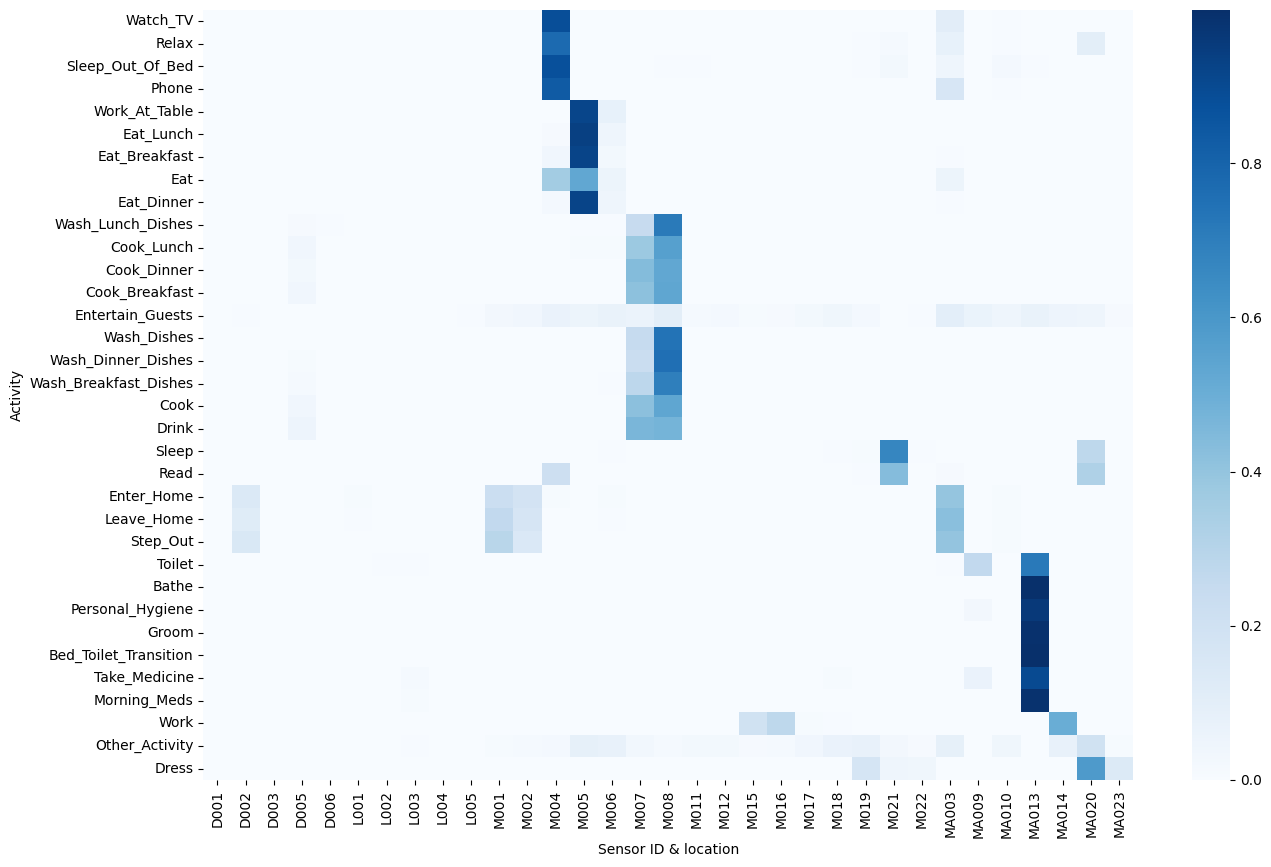

In [100]:
# write a one hot encoding function with index and max len as input
def one_hot_encoding(indices, max_len):
    x_one_hot = np.zeros(max_len)
    for index in indices:
        x_one_hot[index] = 1
    return x_one_hot

sensor_id_count = timeframed_dataset.groupby(['Activity', 'Sensor ID & location']).size().reset_index(name='counts')

# plot the heatmap for activity against the sensor id
sensor_id_count = sensor_id_count.pivot(index='Activity', columns='Sensor ID & location', values='counts')
sensor_id_count = sensor_id_count.fillna(0)

# get the sensor id with max count for each activity
sensor_id_count['max_sensor_id'] = sensor_id_count.idxmax(axis=1)
# sort the sensor id count by max sensor id
sensor_id_count = sensor_id_count.sort_values(by=['max_sensor_id'])
# drop the max sensor id column
sensor_id_count = sensor_id_count.drop(columns=['max_sensor_id'])

# show the activity in the order of their max sensor id count

# normalize the count for each activity
sensor_id_count = sensor_id_count.apply(lambda x: x/x.sum(), axis=1)

# rotate the xtick
# plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(sensor_id_count, cmap='Blues')
# add legend for mapping sensor location id to sensor location
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

# Create a list of the labels and their corresponding values
labels = list(sensor_location2id.keys())
values = list(sensor_location2id.values())

# Plot a dummy scatter plot with the labels and values
# plt.scatter(values, values, label='_nolegend_')
# for i, label in enumerate(labels):
#     plt.scatter(values[i], values[i], label=label)

# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
# plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

In [101]:
sensor_id2index

{'M021': 0,
 'MA020': 1,
 'M019': 2,
 'M018': 3,
 'MA013': 4,
 'M017': 5,
 'MA014': 6,
 'M012': 7,
 'M011': 8,
 'MA010': 9,
 'MA003': 10,
 'M002': 11,
 'M001': 12,
 'D002': 13,
 'M022': 14,
 'L003': 15,
 'M016': 16,
 'M015': 17,
 'M004': 18,
 'M006': 19,
 'M005': 20,
 'M007': 21,
 'D005': 22,
 'M008': 23,
 'MA009': 24,
 'L002': 25,
 'MA023': 26,
 'D006': 27,
 'L005': 28,
 'L004': 29,
 'L001': 30,
 'D001': 31,
 'D003': 32}

In [102]:
from data_hh import load_dataset
# Load the data
sys.path.append('../')
from data_hh import load_dataset

dataset_no = "102"
dataset_path = '../hh_dataset/hh' + dataset_no + '/hh' + dataset_no + '.ann.txt'
print('Dataset loaded')

X, Y, dictActivities, T, dictObs = load_dataset(dataset_path)
print('Data loaded')

output_path = '../similarity_matrix/hh_' + dataset_no + '/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

# y_act = np.array([y for y in dictActivities if y != 'Other_Activity'])
y_act = np.array([y for y in dictActivities])

X_activities = [[x for i, x in enumerate(X) if Y[i] == dictActivities[y]] for y in y_act]
print([len(x) for x in X_activities])


X_activities = [[y for y in x if len(y) > np.quantile([len(y) for y in x], 0.2 if len(x) < 600 else 0.5)] for x in X_activities]

print([len(x) for x in X_activities])
# Is that any zero length activity?
print([len(x) for x in X_activities if len(x) == 0])

# print the number of x in each activity
for i, x in enumerate(X_activities):
    print(y_act[i], len(x))

Dataset loaded
{'Bathe': 0, 'Bed_Toilet_Transition': 1, 'Cook': 2, 'Cook_Breakfast': 3, 'Cook_Dinner': 4, 'Cook_Lunch': 5, 'Dress': 6, 'Drink': 7, 'Eat': 8, 'Eat_Breakfast': 9, 'Eat_Dinner': 10, 'Eat_Lunch': 11, 'Enter_Home': 12, 'Entertain_Guests': 13, 'Groom': 14, 'Leave_Home': 15, 'Morning_Meds': 16, 'Other_Activity': 17, 'Personal_Hygiene': 18, 'Phone': 19, 'Read': 20, 'Relax': 21, 'Sleep': 22, 'Sleep_Out_Of_Bed': 23, 'Step_Out': 24, 'Take_Medicine': 25, 'Toilet': 26, 'Wash_Breakfast_Dishes': 27, 'Wash_Dinner_Dishes': 28, 'Wash_Dishes': 29, 'Wash_Lunch_Dishes': 30, 'Watch_TV': 31, 'Work': 32, 'Work_At_Table': 33}
Data loaded
[78, 137, 80, 250, 580, 181, 247, 396, 19, 72, 104, 52, 123, 10, 327, 124, 94, 6514, 1492, 44, 93, 157, 122, 45, 56, 0, 806, 100, 266, 128, 57, 209, 0, 215]
[36, 49, 38, 119, 246, 84, 197, 191, 15, 47, 66, 31, 95, 8, 116, 86, 52, 2978, 553, 34, 72, 122, 97, 33, 43, 0, 326, 50, 120, 65, 27, 162, 0, 126]
[0, 0]
Bathe 36
Bed_Toilet_Transition 49
Cook 38
Cook_Break

In [103]:
# inverse dictObs
# dictObs_inv = {v: k for k, v in dictObs.items()}
# drop the text 'ON', 'OFF', 'OPEN', 'CLOSE' from the key in dictObs_inv
dictObs_inv = {v : k.replace('ON', '').replace('OFF', '').replace('OPEN', '').replace('CLOSE', '') for k, v in dictObs.items()}

# map item in X_activities back to the original observation based on dictObs_inv
X_activities = [[[dictObs_inv[item] for item in x] for x in X] for X in X_activities]

In [104]:
sensor_location2id

{'Bed': 0,
 'Bedroom': 1,
 'Hall': 2,
 'Bathroom': 3,
 'Office': 4,
 'LivingRoom': 5,
 'FrontDoor': 6,
 'Entry': 7,
 'WorkArea': 8,
 'Chair': 9,
 'DiningRoom': 10,
 'Kitchen': 11,
 'Refrigerator': 12,
 'Closet': 13,
 'Freezer': 14,
 'BathroomDoor': 15}

/home/simon/miniconda3/envs/casas/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator


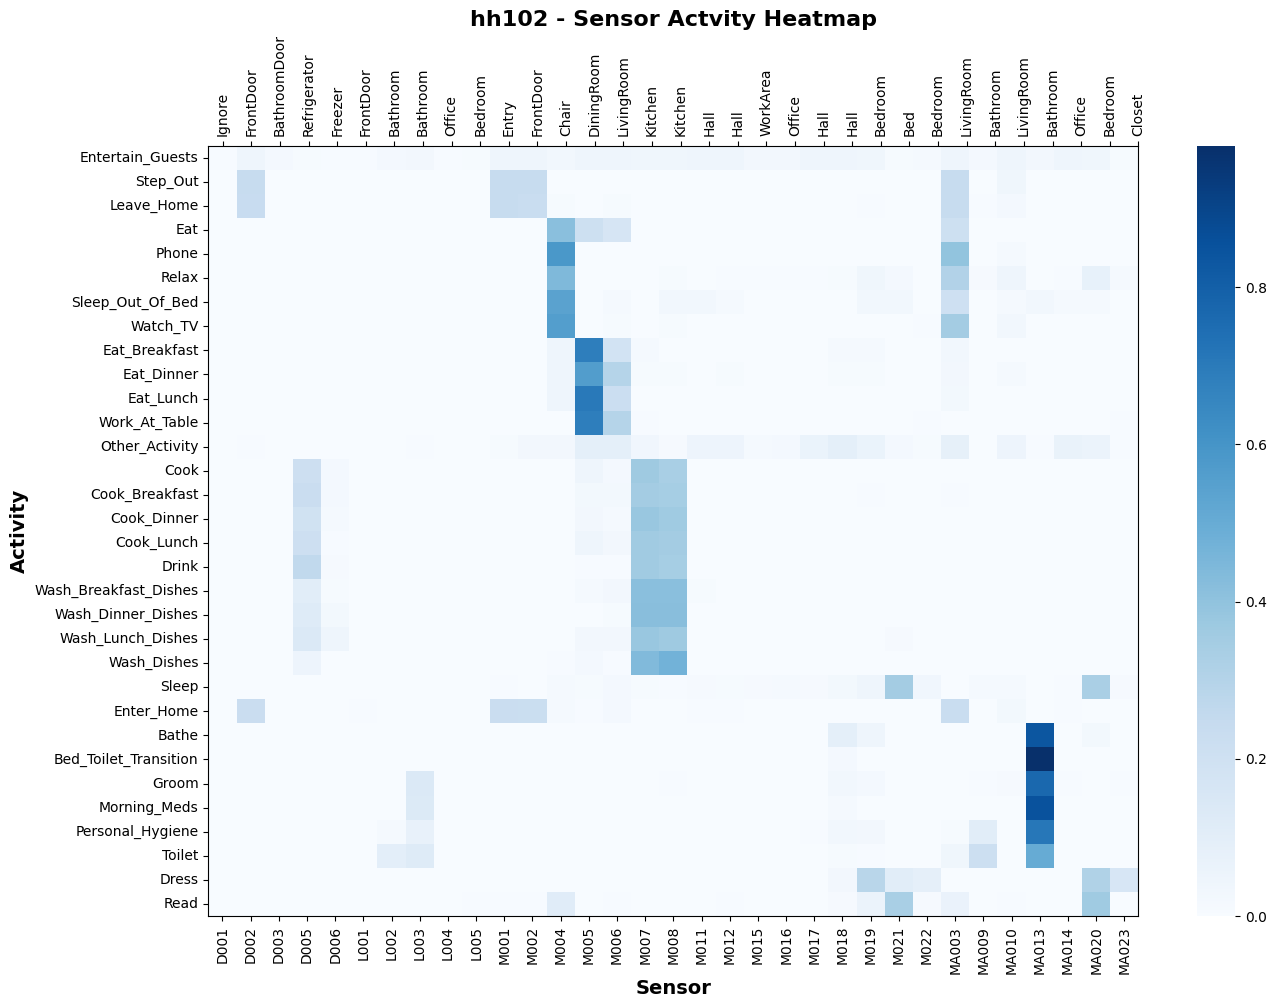

In [105]:
# write a one hot encoding function with index and max len as input
def one_hot_encoding(indices, max_len):
    x_one_hot = np.zeros(max_len)
    for index in indices:
        x_one_hot[index-1] = 1
    return x_one_hot

y_activities = [[y_act[i]] * len(x) for i, x in enumerate(X_activities)]
y_activities = [item for sublist in y_activities for item in sublist]

flat_X_activities = [list(set(item)) for sublist in X_activities for item in sublist]

# create dataframe by combining flat_X_activities and y_activities
df = pd.DataFrame({'X': flat_X_activities, 'Y': y_activities})
# explode the X column by splitting the list
df = df.explode('X')
# pivot the dataframe to get the count of each observation for each activity
df = df.pivot_table(index='Y', columns='X', aggfunc=len, fill_value=0)

# normalize the count for each activity
df = df.apply(lambda x: x/x.sum(), axis=1)

# add a column for sensor location 
# df['sensor_location'] = df.index.map(sensor_id2location)

# get the most frequent observation for each activity
df['max_obs'] = df.idxmax(axis=1)
# sort by the most frequent observation and activity
df = df.sort_values(by=['max_obs', 'Y'])
# drop the max_obs column
df = df.drop(columns=['max_obs'])

fig, ax = plt.subplots(figsize=(15, 10))
# plot the heatmap
sns.heatmap(df, cmap='Blues', ax=ax)
ax.set_xlabel('Sensor', fontweight='bold', fontsize=14)
ax.set_ylabel('Activity', fontweight='bold', fontsize=14)

ax2 = ax.twiny()
xticks = ax.get_xticklabels()
# new_xticklabels = [sensor_id2location[x.get_text()] if (x.get_text() in sensor_id2location) else '' for x in ax.get_xticklabels()]
new_xticklabels = [sensor_id2location[x.get_text()] if (x.get_text() in sensor_id2location) else '' for x in ax.get_xticklabels()]
# set the new xtick labels
# create new text object for the new xtick labels
# new_xticks = [ax.text(x.get_position()[0], -0.5, new_xticklabels[i]) for i, x in enumerate(ax.get_xticklabels())]
# set the new xtick labels
ax2.set_xticklabels(new_xticklabels)
# show all the xtick labels
ax2.set_xticks([x.get_position()[0] for x in ax.get_xticklabels()])
# rotate ax2 xtick labels
plt.setp(ax2.get_xticklabels(), rotation=90)
# set the xlabel for ax2 to Location with bold
# ax2.set_xlabel('Location', fontweight='bold', fontsize=14, labelpad=2)

# Add title for the plot as "hh102 - Sensor Actvity Heatmap"
ax.set_title('hh' + dataset_no + ' - Sensor Actvity Heatmap', fontweight='bold', fontsize=16)
# save the plot as png
output_path = './evaluation/'
plt.savefig(output_path + 'hh' + dataset_no + '_sensor_activity_heatmap.png', bbox_inches='tight')

In [77]:
# # create new xtick labels by replacing the sensor id with sensor location
# new_xticklabels = [sensor_id2location[x.get_text()] if (x.get_text() in sensor_id2location) else '' for x in ax.get_xticklabels()]
# # set the new xtick labels
# new_xticklabels
# # create new text object for the new xtick labels
# new_xticks = [ax2.text(x.get_position()[0], 0, new_xticklabels[i]) for i, x in enumerate(ax.get_xticklabels())]
# new_xticks
# ax.get_xticklabels()
# get the ax2 xtick
ax2.get_xticklabels()

[Text(0.0, 1, 'Ignore'),
 Text(0.2, 1, 'FrontDoor'),
 Text(0.4, 1, 'BathroomDoor'),
 Text(0.6000000000000001, 1, 'Refrigerator'),
 Text(0.8, 1, 'Freezer'),
 Text(1.0, 1, 'FrontDoor')]

In [60]:
[x.get_text() for x in ax.get_xticklabels()]


{'M021': 'Bed',
 'MA020': 'Bedroom',
 'M019': 'Bedroom',
 'M018': 'Hall',
 'MA013': 'Bathroom',
 'M017': 'Hall',
 'MA014': 'Office',
 'M012': 'Hall',
 'M011': 'Hall',
 'MA010': 'LivingRoom',
 'MA003': 'LivingRoom',
 'M002': 'FrontDoor',
 'M001': 'Entry',
 'D002': 'FrontDoor',
 'M022': 'Bedroom',
 'L003': 'Bathroom',
 'M016': 'Office',
 'M015': 'WorkArea',
 'M004': 'Chair',
 'M006': 'LivingRoom',
 'M005': 'DiningRoom',
 'M007': 'Kitchen',
 'D005': 'Refrigerator',
 'M008': 'Kitchen',
 'MA009': 'Bathroom',
 'L002': 'Bathroom',
 'MA023': 'Closet',
 'D006': 'Freezer',
 'L005': 'Bedroom',
 'L004': 'Office',
 'L001': 'FrontDoor',
 'D001': 'Ignore',
 'D003': 'BathroomDoor'}

In [25]:




one_hot_encoded = np.array([one_hot_encoding(list(set(feature)), max_len) for activity_features in X_activities for feature in activity_features])
# len(one_hot_encoded)

<AxesSubplot:ylabel='activity'>

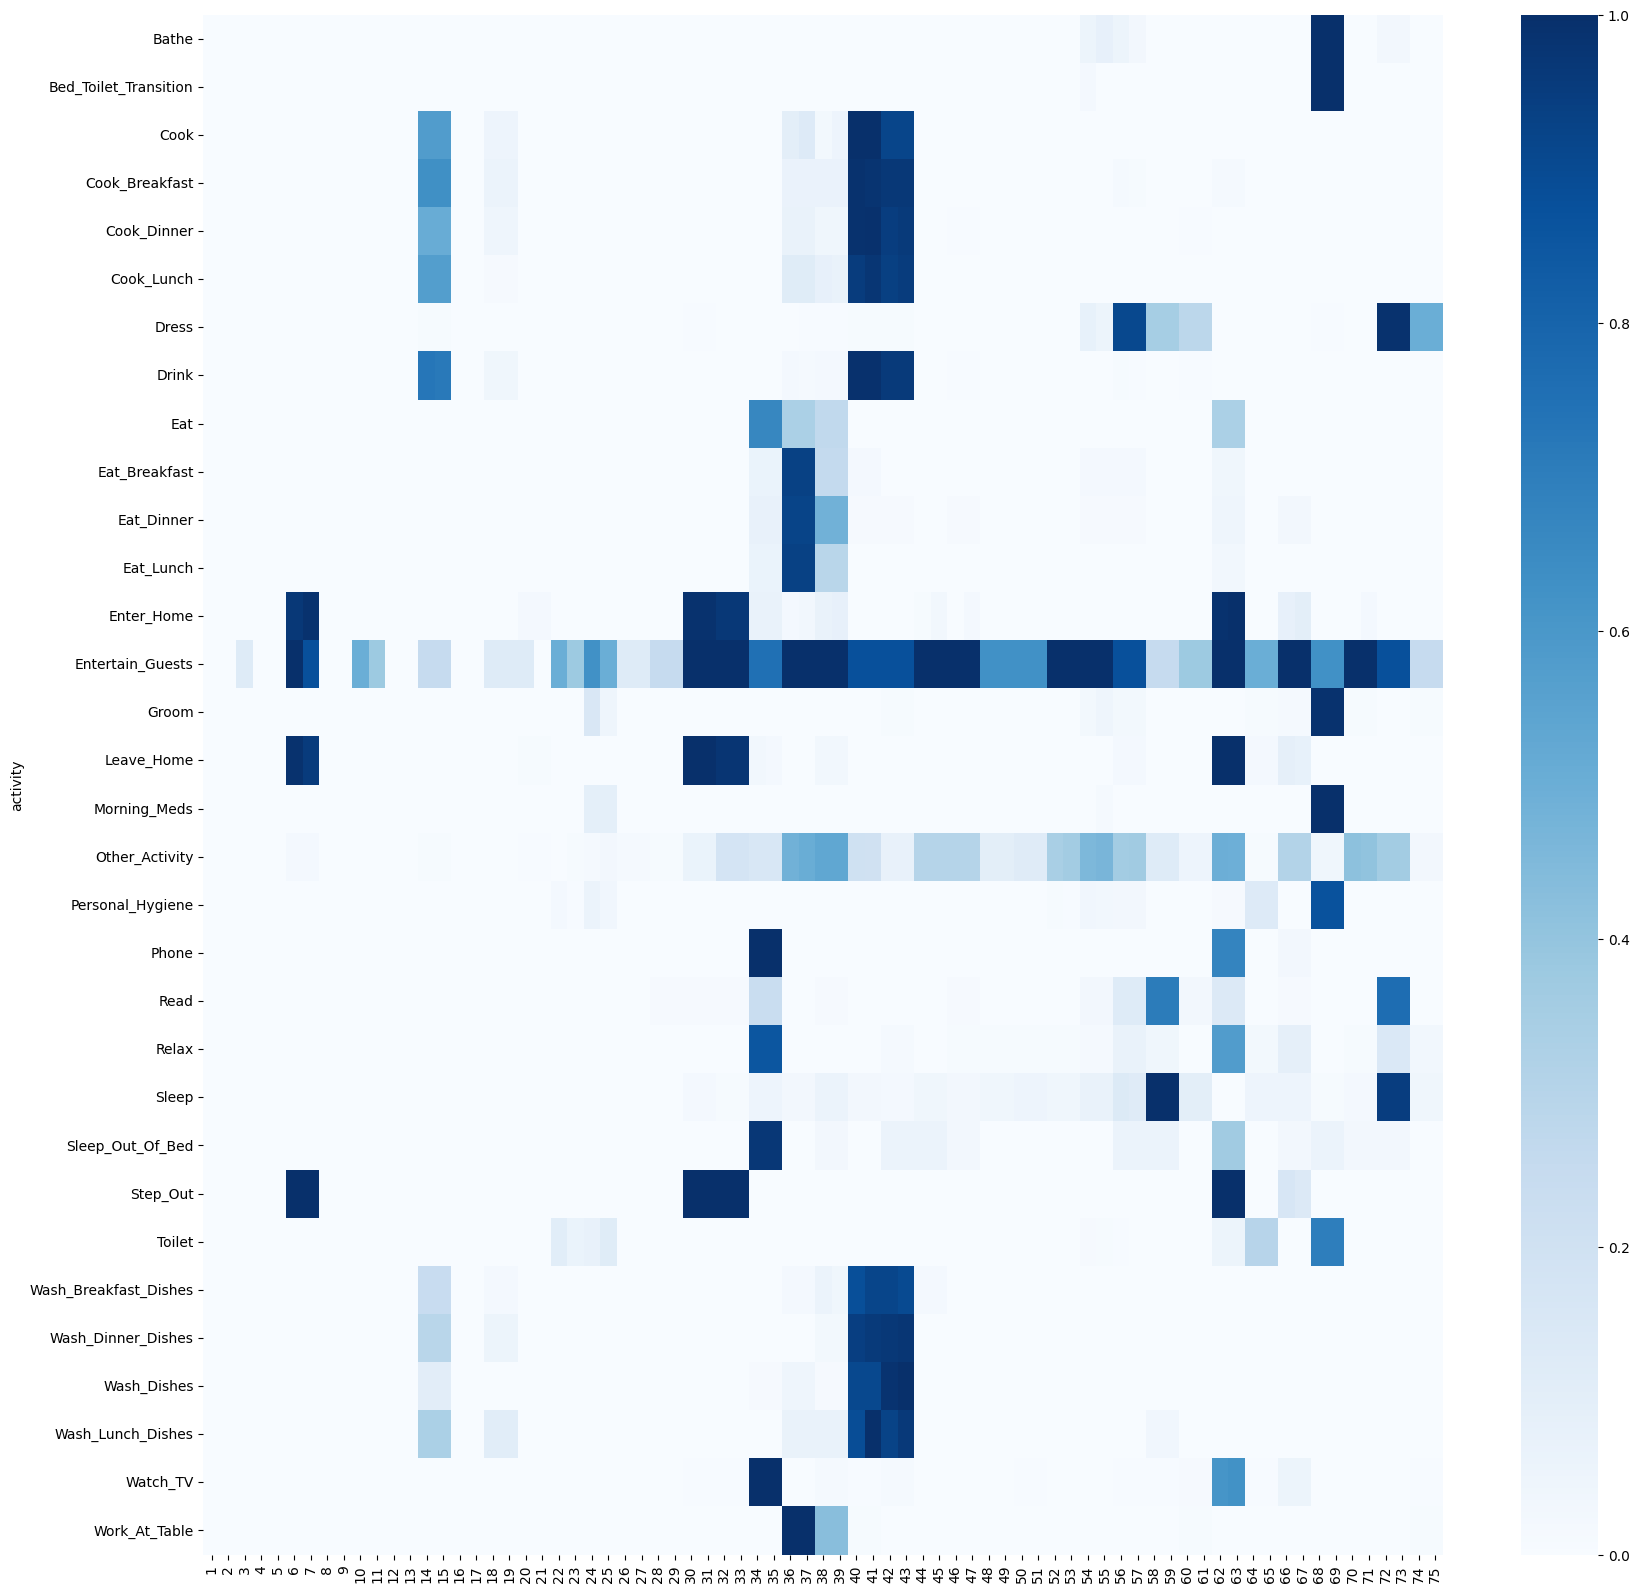

In [7]:
# turn the one hot encoded into a dataframe with its activity
df = pd.DataFrame(one_hot_encoded, columns=[str(i) for i in range(1, max_len+1)])
df['activity'] = y_activities

# aggregate the one hot encoded dataframe for each activity and take the mean of each column
df_agg = df.groupby('activity').mean()

# plot the heatmap of the aggregated dataframe
plt.figure(figsize=(20, 20))
sns.heatmap(df_agg, cmap='Blues')


In [ ]:
# get the id in dictActivities for ['Eat', 'Eat_Breakfast', 'Eat_Lunch', 'Eat_Dinner', 'Wash_Dishes', 'Wash_Breakfast_Dishes', 'Wash_Lunch_Dishes', 'Wash_Dinner_Dishes', 'Cook', 'Cook_Breakfast', 'Cook_Lunch', 'Cook_Dinner']
prior_ids = [dictActivities[x] for x in ['Eat', 'Eat_Breakfast', 'Eat_Lunch', 'Eat_Dinner', 'Wash_Dishes', 'Wash_Breakfast_Dishes', 'Wash_Lunch_Dishes', 'Wash_Dinner_Dishes', 'Cook', 'Cook_Breakfast', 'Cook_Lunch', 'Cook_Dinner']]
prior_ids

In [ ]:
# plot umap for the flatten_top_x according to the top_y_act
scaler = StandardScaler()
X_scaled = scaler.fit_transform(one_hot_encoded)
embedding = umap.UMAP(n_neighbors=30, min_dist=0.05, n_components=2, random_state=42).fit_transform(X_scaled)

In [ ]:
plt.figure(figsize=(20, 10))
# scatter plot of the 2D embedding
# only plot those embedding that their corresponding y_act is in prior_ids
# top_embedding = embedding[[y in prior_ids for y in y_act]]
# top_y_act = y_act[[y in prior_ids for y in y_act]]

# create a dataframe for the embedding and y_act
df = pd.DataFrame(embedding, columns=['x', 'y'])
df['y_act'] = y_activities
df['y_act_id'] = [dictActivities[y] for y in y_activities]
df['y_act_id'] = df['y_act_id'].astype('category')

# filter df by y_act_id that's in prior_ids
# df = df[df['y_act_id'].isin(prior_ids)]

# use seaborn to plot the scatter plot
sns.scatterplot(data=df, x='x', y='y', hue='y_act')

# increase the size of scatter plot
# plt.gca().set_aspect('equal', 'datalim')

# sns.scatter(embedding[:, 0], embedding[:, 1], c=[dictActivities[y] for y in y_activities], s=1, cmap='Spectral')
# plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(len(dictActivities)+1)-0.5).set_ticks(np.arange(len(dictActivities)))
# plt.title('UMAP projection of the hh' + dataset_no + ' dataset', fontsize=24)
# # set x lim and y lim above 0
# plt.xlim(0, 20)
# plt.ylim(0, 20)

In [ ]:
dataset = 'hh102'
features = np.load(f'../hh_dataset/hh_npy/{dataset}_feature.npy')
activities = np.load(f'../hh_dataset/hh_npy/{dataset}_activity.npy')
with open(f'../hh_dataset/hh_npy/fib_hh102_mapping.json') as f:
    activity2id = json.load(f)

In [ ]:
# Plotting the scatter plot
activities_plot = ['Sleep', 'Cook']
for i, activity in enumerate(activities_plot):
    activity_vector = np.zeros(len(activity2id)-1)
    activity_index = [i for i, act in enumerate(activities) if (act[activity2id[activity]] == 1)]
    activity_feature_vector = np.array([feature for i, feature in enumerate(features) if i in activity_index])

    print(f'{activity}: shape{activity_feature_vector.shape}')
    instance, _, _ = activity_feature_vector.shape
    sleep_feature_vectors = activity_feature_vector.reshape((instance, -1))

    dim_reducer=umap.UMAP()
    scaled_data = StandardScaler().fit_transform(sleep_feature_vectors)
    embedding = dim_reducer.fit_transform(scaled_data)
    color_mapping = sns.color_palette("tab10", len(activities))

    plt.scatter(embedding[:, 0], embedding[:, 1], color=color_mapping[i], label=activity)
plt.legend()

In [ ]:
# Plotting the scatter plot
activities_plot = ['Drink', 'Phone', 'Take_Medicine']
for i, activity in enumerate(activities_plot):
    activity_vector = np.zeros(len(activity2id)-1)
    activity_index = [i for i, act in enumerate(activities) if (act[activity2id[activity]] == 1)]
    activity_feature_vector = np.array([feature for i, feature in enumerate(features) if i in activity_index])

    print(f'{activity}: shape{activity_feature_vector.shape}')
    instance, _, _ = activity_feature_vector.shape
    sleep_feature_vectors = activity_feature_vector.reshape((instance, -1))

    dim_reducer=umap.UMAP()
    scaled_data = StandardScaler().fit_transform(sleep_feature_vectors)
    embedding = dim_reducer.fit_transform(scaled_data)
    color_mapping = sns.color_palette("tab10", len(activities))

    plt.scatter(embedding[:, 0], embedding[:, 1], color=color_mapping[i], label=activity)
plt.legend()